In [1]:
from pathlib import Path

import pandas as pd

from tqdm import tqdm
import pul_config
import importlib

importlib.reload(pul_config)

import utils

importlib.reload(utils)
from utils import (
    build_proba_df_obl,
    calc_predictions,
    build_proba_df,
    build_ranked_lists,
    calc_scores,
    load_grid_searches,
    score_df_from_grid_searches,
    train,
    evaluate,
)

# CHANGE HERE
input_dirs = [
    Path("1_outputs/standard/"),
    Path("1_outputs/small_DS/"),
    Path("1_outputs/large/"),
    Path("1_outputs/large_small_DS/"),
]
output_dirs = [
    Path("2_outputs/standard/"),
    Path("2_outputs/small_DS/"),
    Path("2_outputs/large/"),
    Path("2_outputs/large_small_DS/"),
]
method = "Elkanoto_XGBoost"
pul_cfg = pul_config.ElkanotoXGBoostConfig

remote_method = "Elkanoto_XGBoost"  # name of the output in S3
# -----

local_method = method
# MODEL_NAMES = ('RotatE', 'TransE', )
MODEL_NAMES = ("RotatE", "TransE", "CompGCN")
output_dirs = [output_dir / method for output_dir in output_dirs]

## Training

In [2]:
N_JOBS = 40
CV = 5
rerun = False

for input_dir, output_dir in tqdm(zip(input_dirs, output_dirs), total=len(input_dirs)):
    train(
        input_dir=input_dir,
        output_dir=output_dir,
        model_names=MODEL_NAMES,
        cv=CV,
        n_jobs=N_JOBS,
        pul_cfg=pul_cfg,
        rerun=rerun,
    )

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:59<08:53, 59.27s/it]

 20%|██        | 2/10 [01:14<04:24, 33.12s/it]

 30%|███       | 3/10 [01:29<02:54, 24.92s/it]

 40%|████      | 4/10 [01:44<02:05, 20.95s/it]

 50%|█████     | 5/10 [01:59<01:34, 18.87s/it]

 60%|██████    | 6/10 [02:14<01:10, 17.52s/it]

 70%|███████   | 7/10 [02:29<00:50, 16.68s/it]

 80%|████████  | 8/10 [02:44<00:32, 16.17s/it]

 90%|█████████ | 9/10 [02:58<00:15, 15.73s/it]

100%|██████████| 10/10 [03:14<00:00, 19.41s/it]

 33%|███▎      | 1/3 [03:14<06:28, 194.20s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:05<00:48,  5.39s/it]

 20%|██        | 2/10 [00:10<00:42,  5.35s/it]

 30%|███       | 3/10 [00:15<00:36,  5.27s/it]

 40%|████      | 4/10 [00:21<00:31,  5.24s/it]

 50%|█████     | 5/10 [00:26<00:26,  5.26s/it]

 60%|██████    | 6/10 [00:32<00:21,  5.40s/it]

 70%|███████   | 7/10 [00:38<00:16,  5.60s/it]

 80%|████████  |

## Evaluation

In [4]:
grid_searches_list = [
    load_grid_searches(output_dir=o, model_names=MODEL_NAMES) for o in output_dirs
]

In [5]:
score_dfs = [
    score_df_from_grid_searches(gs, i) for gs, i in zip(grid_searches_list, input_dirs)
]
for output_dir, score_df in zip(output_dirs, score_dfs):
    score_df.to_csv(output_dir / "score_df.csv")

In [6]:
score_dfs[0].groupby("model_name").mean()

/tmp/ipykernel_37404/1470429527.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  score_dfs[0].groupby('model_name').mean()


,score10_val,score100_val,score10_test,score100_test,score10_all,score100_all,mr_all,mrr_all,amri_all,mr_test,mrr_test,amri_test,tp_test,fp_test,fn_test,tn_test,tp_all,fp_all,fn_all,tn_all
model_name,,,,,,,,,,,,,,,,,,,,
CompGCN,2.0,18.3,1.7,18.4,7.4,51.0,3172.083199,0.006576,0.675990,871.0848,0.010943,0.553803,2871.3,904.7,44.2,80.8,14572.1,4383.9,143.6,475.4
RotatE,7.3,42.8,8.9,43.0,9.4,89.9,1483.091276,0.009900,0.848565,405.2152,0.032577,0.792710,3585.9,190.1,54.7,70.3,18098.3,857.7,171.8,447.2
TransE,7.0,35.2,6.8,39.4,8.5,84.8,1468.007754,0.009061,0.850106,466.6776,0.026017,0.761191,3528.7,247.3,51.4,73.6,17803.4,1152.6,150.2,468.8


Text(0, 0.5, 'score')

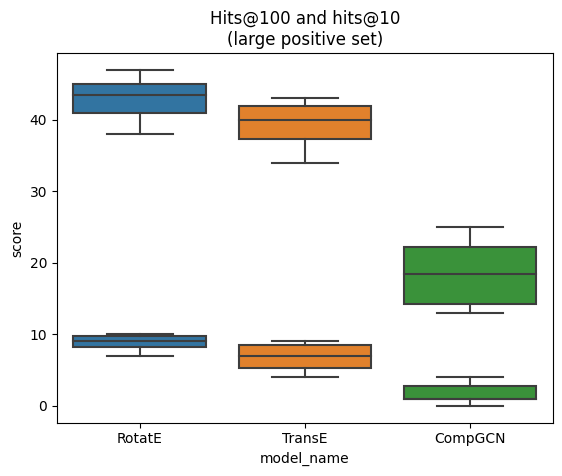

In [7]:
import seaborn as sns

sns.boxplot(score_dfs[0], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(large positive set)"
)
sns.boxplot(score_dfs[0], x="model_name", y="score100_test").set_ylabel("score")

Text(0, 0.5, 'score')

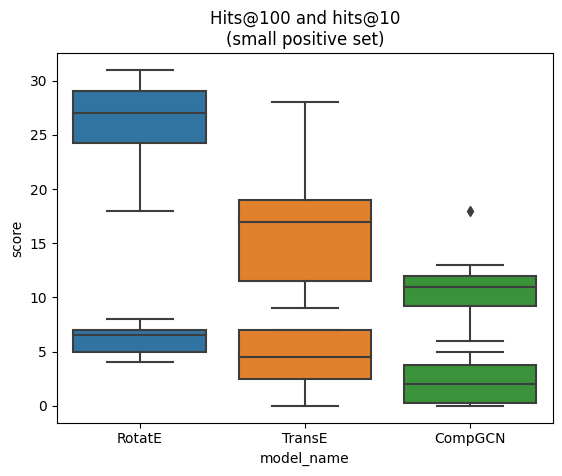

In [8]:
import seaborn as sns

sns.boxplot(score_dfs[1], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(small positive set)"
)
sns.boxplot(score_dfs[1], x="model_name", y="score100_test").set_ylabel("score")

Text(0, 0.5, 'score')

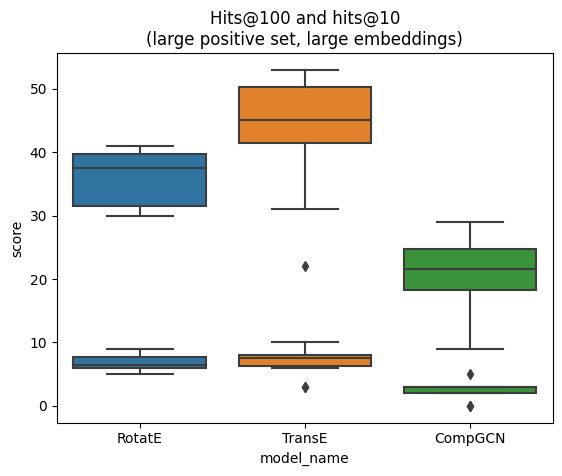

In [9]:
import seaborn as sns

sns.boxplot(score_dfs[2], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(large positive set, large embeddings)"
)
sns.boxplot(score_dfs[2], x="model_name", y="score100_test").set_ylabel("score")

Text(0, 0.5, 'score')

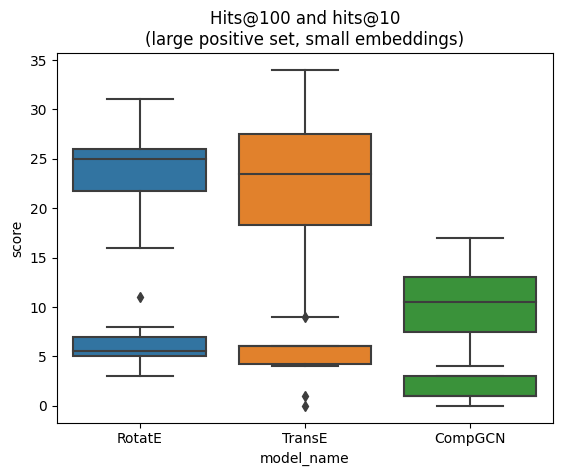

In [10]:
import seaborn as sns

sns.boxplot(score_dfs[3], x="model_name", y="score10_test").set(
    title="Hits@100 and hits@10\n(large positive set, small embeddings)"
)
sns.boxplot(score_dfs[3], x="model_name", y="score100_test").set_ylabel("score")

In [11]:
score_dfs = []
for output_dir in output_dirs:
    score_dfs.append(pd.read_csv(output_dir / "score_df.csv", index_col=0))
plot_dfs = []
for ds, score_df in zip(
    ("large", "small", "large_embeddings", "large_embeddings_small"), score_dfs
):
    plot_df = score_df[["model_name", "score10_test", "score100_test"]].copy()
    plot_df.columns = ["model_name", "hits@10", "hits@100"]
    plot_df["dataset"] = ds
    plot_dfs.append(plot_df)

plot_df = pd.concat(plot_dfs)
plot_df = plot_df.melt(id_vars=["model_name", "dataset"])
plot_dfs = {k: v for k, v in plot_df.groupby("model_name")}

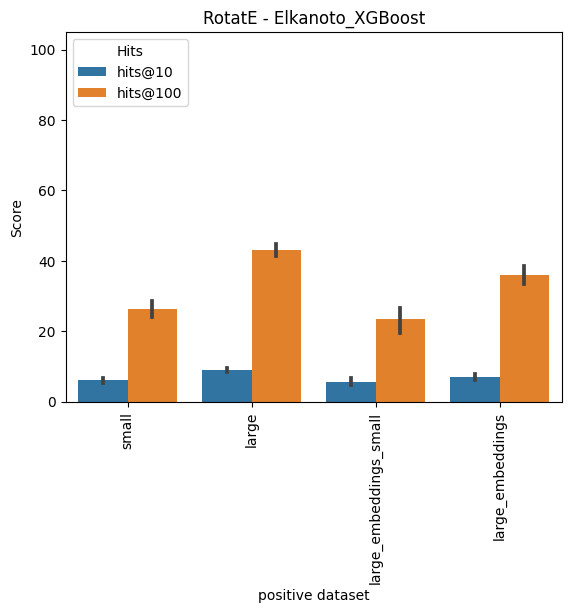

In [12]:
y_lim = (0, 105)
y_label = "Score"

import seaborn as sns
import matplotlib.pyplot as plt

model_name = "RotatE"
plot_df = plot_dfs[model_name]

plot_df["Hits"] = plot_df["variable"]
plot = sns.barplot(
    plot_df,
    x="dataset",
    y="value",
    hue="Hits",
    order=["small", "large", "large_embeddings_small", "large_embeddings"],
)
sns.move_legend(plot, "upper left")
plot.set(xlabel="positive dataset", ylabel=y_label)
plot.set_title(f"{model_name} - {method}")
plot.set_ylim(y_lim)
_ = plot.set_xticklabels(
    labels=["small", "large", "large_embeddings_small", "large_embeddings"], rotation=90
)

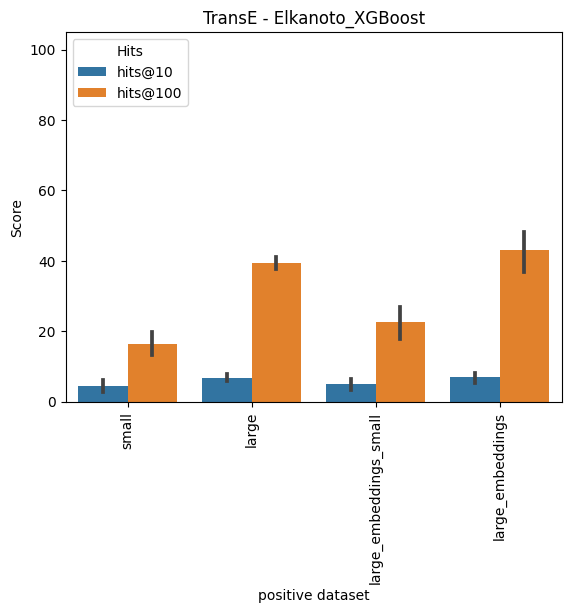

In [13]:
y_lim = (0, 105)
y_label = "Score"

import seaborn as sns
import matplotlib.pyplot as plt

model_name = "TransE"
plot_df = plot_dfs[model_name]

plot_df["Hits"] = plot_df["variable"]
plot = sns.barplot(
    plot_df,
    x="dataset",
    y="value",
    hue="Hits",
    order=["small", "large", "large_embeddings_small", "large_embeddings"],
)
sns.move_legend(plot, "upper left")
plot.set(xlabel="positive dataset", ylabel=y_label)
plot.set_title(f"{model_name} - {method}")
plot.set_ylim(y_lim)
_ = plot.set_xticklabels(
    labels=["small", "large", "large_embeddings_small", "large_embeddings"], rotation=90
)

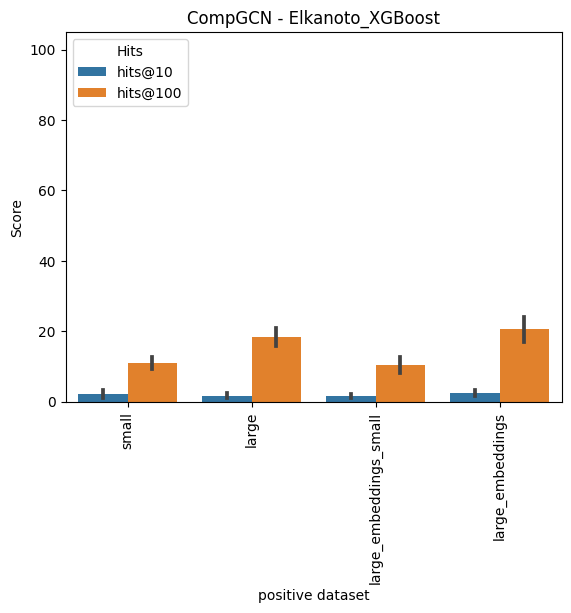

In [14]:
y_lim = (0, 105)
y_label = "Score"

import seaborn as sns
import matplotlib.pyplot as plt

model_name = "CompGCN"
plot_df = plot_dfs[model_name]

plot_df["Hits"] = plot_df["variable"]
plot = sns.barplot(
    plot_df,
    x="dataset",
    y="value",
    hue="Hits",
    order=["small", "large", "large_embeddings_small", "large_embeddings"],
)
sns.move_legend(plot, "upper left")
plot.set(xlabel="positive dataset", ylabel=y_label)
plot.set_title(f"{model_name} - {method}")
plot.set_ylim(y_lim)
_ = plot.set_xticklabels(
    labels=["small", "large", "large_embeddings_small", "large_embeddings"], rotation=90
)

In [15]:
proba_dfs = [
    build_proba_df_obl(
        gs, i, mns=MODEL_NAMES, gene_df_file="../topological_features/data/gene_df.csv"
    )
    for gs, i in zip(grid_searches_list, input_dirs)
]
for output_dir, proba_df in zip(output_dirs, proba_dfs):
    proba_df.to_csv(output_dir / "proba_df.csv")

In [16]:
proba_df = proba_dfs[0]
proba_df.query("test").sort_values("RotatE_0", ascending=False)

,node_id,gene_name,irr,train,val,test,RotatE_0,RotatE_1,RotatE_2,RotatE_3,...,CompGCN_0,CompGCN_1,CompGCN_2,CompGCN_3,CompGCN_4,CompGCN_5,CompGCN_6,CompGCN_7,CompGCN_8,CompGCN_9
84924,NCBIGENE:6720,SREBF1,True,False,False,True,3.569659,2.122144,1.000221,1.172863,...,0.635463,1.496822,0.466217,0.991420,0.334229,0.237412,1.720271,1.089606,0.291878,0.205743
78474,NCBIGENE:3643,INSR,True,False,False,True,3.455909,3.228740,2.149230,1.594683,...,4.415754,1.752991,3.853032,0.474639,1.027745,0.181922,1.330387,1.469026,1.607680,1.859665
79196,NCBIGENE:3952,LEP,True,False,False,True,3.412799,3.819900,3.602282,3.495804,...,0.591020,1.496822,3.062928,0.495564,0.221070,2.120321,1.525918,2.174891,1.059152,0.821451
74149,NCBIGENE:1906,EDN1,True,False,False,True,3.375323,3.601868,2.747332,1.156449,...,2.311906,1.116269,2.106349,0.461286,2.346380,1.646384,2.661720,1.507654,1.908503,0.487978
76495,NCBIGENE:2688,GH1,True,False,False,True,3.227359,2.035798,3.160737,3.086938,...,0.481913,1.752991,3.456211,0.423824,0.582335,2.117236,3.696256,1.863385,2.359751,4.635799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70515,NCBIGENE:10146,G3BP1,False,False,False,True,0.006524,0.033058,0.012131,0.190036,...,0.108295,0.182059,0.064915,0.050972,0.033386,0.016250,0.046459,0.312240,0.031556,0.170271
89172,NCBIGENE:9577,BABAM2,False,False,False,True,0.006503,0.023904,0.033941,0.115858,...,0.232966,0.155634,0.203418,0.469658,0.251015,0.034378,0.052884,0.493952,0.088022,0.789608
86071,NCBIGENE:7936,NELFE,False,False,False,True,0.006464,0.007539,0.022167,0.159338,...,0.828338,0.182059,0.168887,0.135600,0.181932,0.055363,0.167013,0.333506,0.044100,0.097635
83613,NCBIGENE:5930,RBBP6,False,False,False,True,0.006464,0.009104,0.010365,0.115858,...,0.113058,0.182059,0.177025,0.169683,0.153183,0.112618,0.045508,0.761141,0.030663,0.528725


In [17]:
for proba_df, score_df, od in zip(proba_dfs, score_dfs, output_dirs):
    proba_df.to_csv(od / "proba_df.csv")
    proba_df.query("test").to_csv(od / "proba_df_test.csv")
    score_df.to_csv(od / "score_df.csv")

    for mn in MODEL_NAMES:
        score_cols = [c for c in proba_df.columns if c.startswith(f"{mn}_")]
        tmp_df = proba_df[
            ["node_id", "gene_name", "irr", "train", "val", "test", *score_cols]
        ]
        tmp_df.to_csv(od / f"proba_df_{mn}.csv")
        tmp_df_test = tmp_df.query("test")
        tmp_df_test.to_csv(od / f"proba_df_test_{mn}.csv")

        genes_100 = build_ranked_lists(tmp_df, prefix=mn)
        genes_100.to_csv(od / f"genes_100_{mn}.csv", index=False)
        genes_100_test = build_ranked_lists(tmp_df_test, prefix=mn)
        genes_100_test.to_csv(od / f"genes_100_test_{mn}.csv", index=False)

        ds = "test"
        score_df_tmp = score_df.query("model_name == @mn")
        score_df_tmp = pd.concat(
            [score_df_tmp["m_name"], score_df_tmp.filter(regex=f".*_{ds}", axis=1)],
            axis=1,
        ).set_index("m_name")
        score_df_tmp.columns = [
            c.replace(f"_{ds}", "").replace("score", "hits@")
            for c in score_df_tmp.columns
        ]
        score_df_tmp = score_df_tmp.T
        score_df_tmp["mean"] = score_df_tmp.mean(axis=1)
        score_df_tmp.to_csv(od / f"scores_{ds}_{mn}.csv", index_label="score")

        ds = "all"
        score_df_tmp = score_df.query("model_name == @mn")
        score_df_tmp = pd.concat(
            [score_df_tmp["m_name"], score_df_tmp.filter(regex=f".*_{ds}", axis=1)],
            axis=1,
        ).set_index("m_name")
        score_df_tmp.columns = [
            c.replace(f"_{ds}", "").replace("score", "hits@")
            for c in score_df_tmp.columns
        ]
        score_df_tmp = score_df_tmp.T
        score_df_tmp["mean"] = score_df_tmp.mean(axis=1)
        score_df_tmp.to_csv(od / f"scores_{mn}.csv", index_label="score")